In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import sys
sys.version

'3.10.0 | packaged by conda-forge | (default, Nov 10 2021, 13:20:59) [MSC v.1916 64 bit (AMD64)]'

In [358]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from fast_ml.feature_selection import get_constant_features
import datetime as dt
from sklearn.preprocessing import PowerTransformer, StandardScaler
import scipy.stats as stats
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples

%matplotlib inline

In [5]:
df = pd.read_csv('online_retail_II.csv')

In [6]:
df.shape

(1067371, 8)

In [7]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [8]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


### Observations from df.describe -

1. The substantial gap between the mean and standard deviation in Quantity and Price highlights the extensive variability within the dataset.
<br>

2. The presence of negative values in both Quantity and Price suggests the existence of anomalies or irregularities in the data.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [10]:
df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

### Insights from df.info and missing value analysis - 

1. There is a need for data type conversion in columns such as InvoiceDate and StockCode.
<br>

2. Null values are identified in the Description and Customer ID fields.
    - The presence of null values in Customer ID is noteworthy, given its unique nature. However, the occurrence of null values in the Description field poses a more significant challenge, as adding arbitrary text would lack meaningful context.

### Checking for Duplicates

In [11]:
df.duplicated().sum()

34335

In [12]:
df[df.duplicated()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
371,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
383,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329.0,United Kingdom
384,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2009-12-01 11:34:00,0.65,16329.0,United Kingdom
385,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067136,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
1067150,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
1067153,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
1067160,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


## We cannot delete rows from this because - 

(Will take example of the first 5 rows from the resultant Data frame above)

1. __*Grouped Invoice:*__
    - These rows seem to be part of the same invoice (Invoice number 489517), indicating that they might belong to a single transaction.

2. __*Variety of Items:*__
    - The 'StockCode' and 'Description' columns have different values for each row, suggesting that multiple items were purchased in this transaction.

3. __*Quantity and Price Variation:*__
    - The 'Quantity' and 'Price' columns differ across rows, indicating that different quantities of various items were purchased, each with its corresponding price.

4. __*Consistent Customer and Location:*__
     - The 'Customer ID' and 'Country' remain constant across these rows, indicating that these items were bought by the same customer in the United Kingdom.



#### In straightforward terms, we refrain from labeling these rows as entirely duplicated since they are 'almost' identical but not entirely equivalent.

#### A unique invoice number and customerID with varying stockcode, description, and price suggest that a single customer/wholesaler has placed an order for multiple items.

#### Omitting these rows would hinder our ability to segment and perform RFM analysis. Consequently, we opt to retain these rows.

### Checking for Constant & Quasi-Constant Features

In [13]:
get_constant_features(df)

,Desc,Var,Value,Perc


### Null values

In [14]:
df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

### We can fill in the customerID with min(customerID) - 1 with respect to geographic locations so we do not have duplicate IDs from different locations. 

In [15]:
df.loc[df['Customer ID'].isna(), ['Customer ID',]]

,Customer ID
263,NaN
283,NaN
284,NaN
470,NaN
577,NaN
...,...
1066997,NaN
1066998,NaN
1066999,NaN
1067000,NaN


In [16]:
def fillna_customerid(countries):
    
    for country in countries:
        temp_df = df.loc[df['Country'] == country, ['Customer ID']]
        min_id = temp_df.min()[0]
        
        df['Customer ID'].loc[(df['Country'] == country) & df['Customer ID'].isna()] = min_id - 1

fillna_customerid(df['Country'].unique().tolist())

In [17]:
df.isna().sum()

Invoice           0
StockCode         0
Description    4382
Quantity          0
InvoiceDate       0
Price             0
Customer ID     398
Country           0
dtype: int64

In [18]:
rows = df.loc[df['Customer ID'].isna(), ['Customer ID', 'Country']]
rows['Country'].unique()

array(['Bermuda', 'Hong Kong'], dtype=object)

In [19]:
df.loc[df['Country'] == 'Bermuda', ['Customer ID', 'Country']]

,Customer ID,Country
128120,NaN,Bermuda
128121,NaN,Bermuda
128122,NaN,Bermuda
128123,NaN,Bermuda
128124,NaN,Bermuda
128125,NaN,Bermuda
128126,NaN,Bermuda
128127,NaN,Bermuda
128128,NaN,Bermuda
128129,NaN,Bermuda


In [20]:
df.loc[df['Country'] == 'Hong Kong', ['Customer ID', 'Country']]

,Customer ID,Country
167607,NaN,Hong Kong
167608,NaN,Hong Kong
167609,NaN,Hong Kong
167610,NaN,Hong Kong
167611,NaN,Hong Kong
...,...,...
949237,NaN,Hong Kong
949238,NaN,Hong Kong
949239,NaN,Hong Kong
990884,NaN,Hong Kong


- The problem with countries like Bermuda and Hong Kong is that it does not have any Customer ID and everything is Nan. Substituting any value should not matter over here. 

- But for safer side and clarity, it is better to take the minimum most value in the entire Customer ID and subtract it by 1 and 2 and substitute it with this values of Bermuda and Hong Kong respectively.

- This step is done by keeping in mind that we "might" have to Scale the values while doing clustering or RFM analysis and if the Nan values in these countries are substituted by 0 and 1 or some other random values, the Scaling algorithm might give it higher/lower importance. To avoid this, we do the previous step. 

In [21]:
hong_kong_id = df['Customer ID'].min() - 1
bermuda_id = df['Customer ID'].min() - 2

df['Customer ID'].loc[(df['Country'] == 'Hong Kong') & df['Customer ID'].isna()] = hong_kong_id
df['Customer ID'].loc[(df['Country'] == 'Bermuda') & df['Customer ID'].isna()] = bermuda_id

In [22]:
df.isna().sum()

Invoice           0
StockCode         0
Description    4382
Quantity          0
InvoiceDate       0
Price             0
Customer ID       0
Country           0
dtype: int64

In [23]:
df['Description']

0          15CM CHRISTMAS GLASS BALL 20 LIGHTS
1                           PINK CHERRY LIGHTS
2                          WHITE CHERRY LIGHTS
3                 RECORD FRAME 7" SINGLE SIZE 
4               STRAWBERRY CERAMIC TRINKET BOX
                          ...                 
1067366           CHILDREN'S APRON DOLLY GIRL 
1067367          CHILDRENS CUTLERY DOLLY GIRL 
1067368        CHILDRENS CUTLERY CIRCUS PARADE
1067369          BAKING SET 9 PIECE RETROSPOT 
1067370                                POSTAGE
Name: Description, Length: 1067371, dtype: object

In [24]:
df['Description'].isna().sum()

4382

In [25]:
country_list = df.loc[df['Description'].isna(), ['Description','Country']]

country_list['Country'].unique()


array(['United Kingdom'], dtype=object)

- All missing description belong from United Kingdom. 

- Removing 4382 rows with missing description from a pool of 1,067,371 rows will not matter much. Additionally, a lot of data is present with United Kingdom as demograph.

- Hence, dropping all values with Nan from Description. 

In [26]:
df.dropna(subset=['Description'], inplace=True)

In [27]:
df.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [28]:
df.shape

(1062989, 8)

## Data Analysis, Processing and Engineering

In [29]:
df['Country'].value_counts()

Country
United Kingdom          976948
EIRE                     17866
Germany                  17624
France                   14330
Netherlands               5140
Spain                     3811
Switzerland               3189
Belgium                   3123
Portugal                  2620
Australia                 1913
Channel Islands           1664
Italy                     1534
Norway                    1455
Sweden                    1364
Cyprus                    1176
Finland                   1049
Austria                    938
Denmark                    817
Unspecified                756
Greece                     663
Japan                      582
Poland                     535
USA                        535
United Arab Emirates       500
Israel                     371
Hong Kong                  364
Singapore                  346
Malta                      299
Iceland                    253
Canada                     228
Lithuania                  189
RSA                        169


#### Checking - With Respect to a country, how many customers are there. 

In [30]:
customer_count = df.groupby('Country')['Customer ID'].nunique().sort_values(ascending=False)
print(customer_count)

Country
United Kingdom          5411
Germany                  107
France                    96
Spain                     41
Belgium                   29
Portugal                  25
Switzerland               23
Netherlands               23
Sweden                    20
Italy                     17
Australia                 15
Finland                   15
Channel Islands           14
Austria                   13
Norway                    13
Denmark                   12
Cyprus                    11
Japan                     10
USA                        9
Unspecified                8
Poland                     6
EIRE                       6
Greece                     5
Canada                     5
United Arab Emirates       5
Israel                     5
Bahrain                    3
RSA                        3
Nigeria                    2
Brazil                     2
Malta                      2
Lebanon                    2
Korea                      2
Bermuda                    1
Thaila

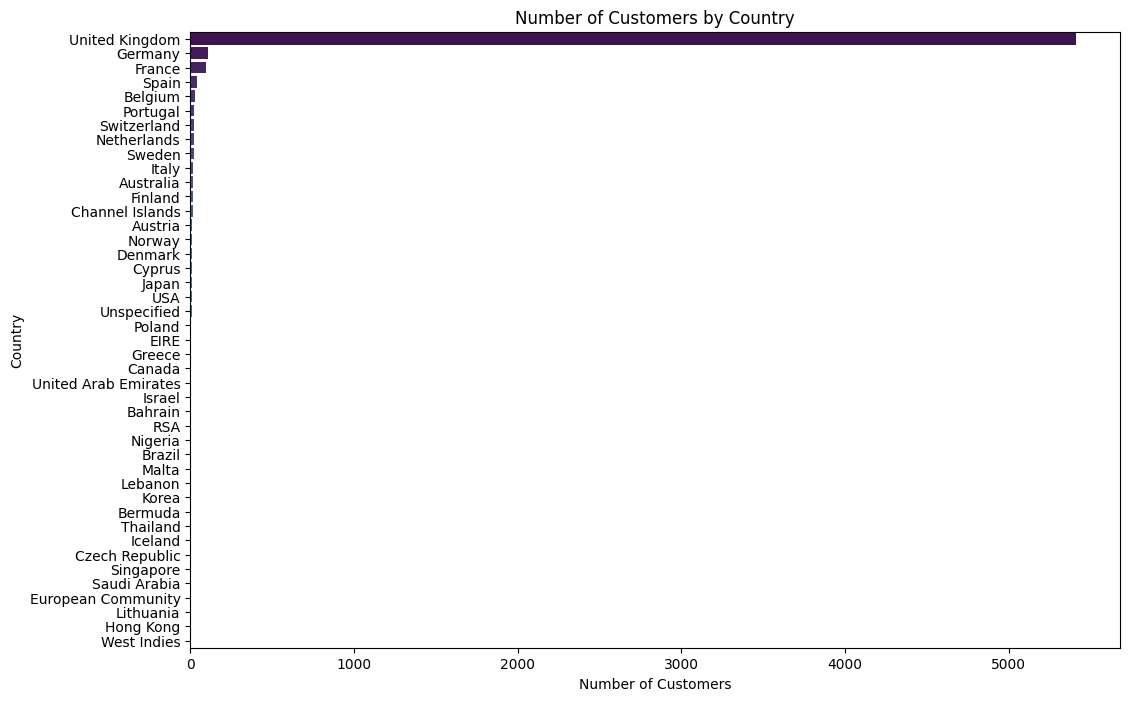

In [31]:
plt.figure(figsize=(12, 8))
sns.barplot(x=customer_count.values, y=customer_count.index, palette='viridis')
plt.xlabel('Number of Customers')
plt.ylabel('Country')
plt.title('Number of Customers by Country')
plt.show()

### Observations from groupby and graph - 

1. UK has most of the customers (of course!)
2. There is an unspecified country. 

## Checking the Distribution of Customers/Wholesalers with respect to Continents

In [32]:
country_to_continent_mapping = {
    'United Kingdom': 'Europe',
    'Germany': 'Europe',
    'France': 'Europe',
    'Spain': 'Europe',
    'Belgium': 'Europe',
    'Portugal': 'Europe',
    'Netherlands': 'Europe',
    'Switzerland': 'Europe',
    'Sweden': 'Europe',
    'Italy': 'Europe',
    'Australia': 'Australia',
    'Finland': 'Europe',
    'Channel Islands': 'Europe',
    'Austria': 'Europe',
    'Norway': 'Europe',
    'Denmark': 'Europe',
    'Cyprus': 'Europe',
    'Japan': 'Asia',
    'USA': 'North America',
    'Unspecified': 'Unspecified',
    'Poland': 'Europe',
    'Canada': 'North America',
    'Greece': 'Europe',
    'EIRE': 'Europe',
    'United Arab Emirates': 'Middle East',
    'Israel': 'Middle East',
    'Korea': 'Asia',
    'Bahrain': 'Middle East',
    'Malta': 'Europe',
    'RSA': 'Africa',
    'Brazil': 'South America',
    'Iceland': 'Europe',
    'Thailand': 'Asia',
    'Czech Republic': 'Europe',
    'Singapore': 'Asia',
    'Saudi Arabia': 'Middle East',
    'Nigeria': 'Africa',
    'European Community': 'Europe',
    'Lithuania': 'Europe',
    'Lebanon': 'Middle East',
    'West Indies': 'North America',
    'Bermuda': 'North America',
    'Hong Kong': 'Asia'}

continent = df['Country'].map(country_to_continent_mapping)

continent

# ! Europe ! - United Kingdom, Germany, France, Spain, Belgium, Portugal, Netherlands, Switzerland, Sweden, Italy, 
# Finland, Channel Islands, Austria, Norway, Denmark, Cyprus, Poland, Greece, EIRE, Malta, Iceland, Czech Republic, 
# European Community, Lithuania

# ! Asia ! - Japan, Korea, Thailand, Singapore, Hong Kong

# ! North America ! - USA, Canada, West Indies, Bermuda

# ! Middle East ! - United Arab Emirates

# ! Africa ! - RSA, Nigeria

# ! South America ! - Brazil

# ! Unspecified ! - Unspecified

0          Europe
1          Europe
2          Europe
3          Europe
4          Europe
            ...  
1067366    Europe
1067367    Europe
1067368    Europe
1067369    Europe
1067370    Europe
Name: Country, Length: 1062989, dtype: object

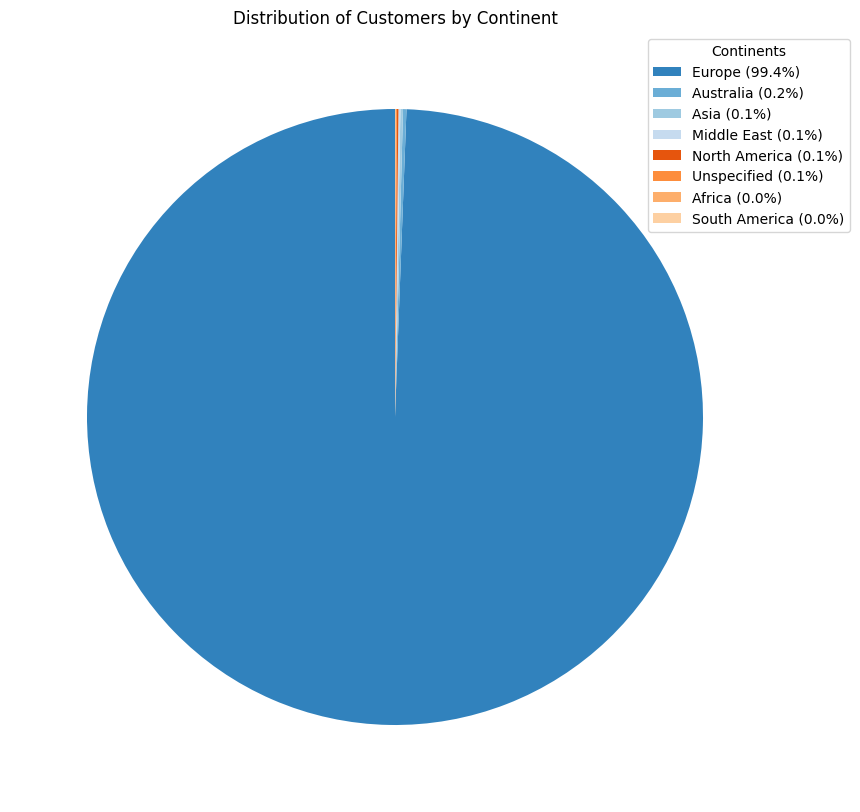

In [33]:
continent_count = continent.value_counts()

plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(continent_count, labels=None, autopct='', startangle=90, colors=plt.cm.tab20c.colors)

legend_labels = [f'{label} ({percentage:.1f}%)' for label, percentage in zip(continent_count.index, continent_count / continent_count.sum() * 100)]
plt.legend(wedges, legend_labels, title='Continents', loc='upper right', bbox_to_anchor=(1.1, 1))

plt.title('Distribution of Customers by Continent')
plt.show()

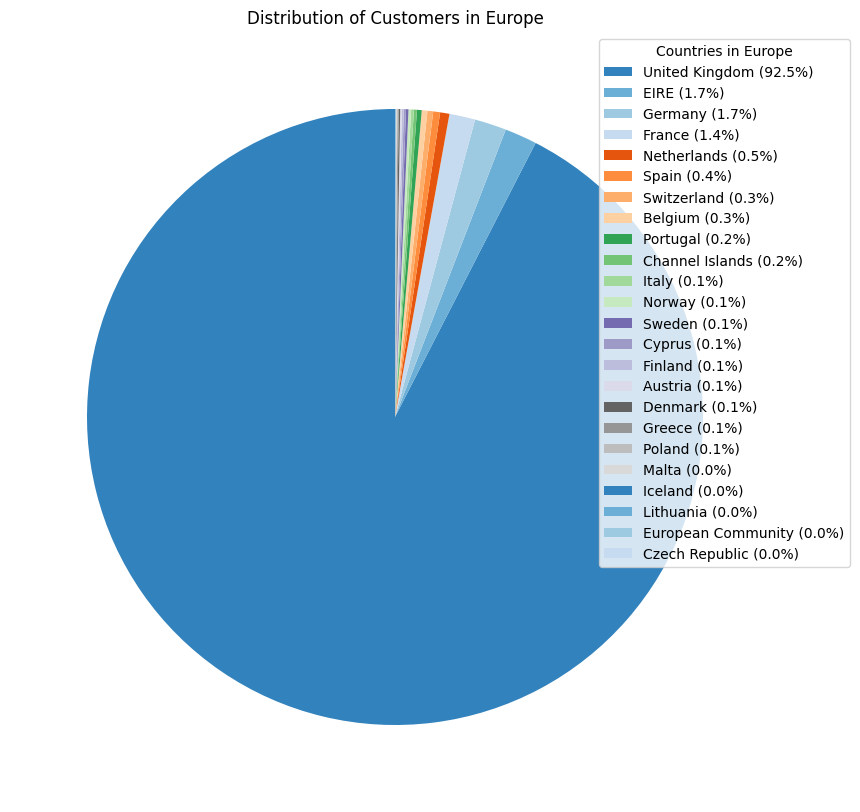

In [34]:
europe_df = df[continent == 'Europe']

europe_count = europe_df['Country'].value_counts()

plt.figure(figsize=(10,10))
wedges, texts, autotexts = plt.pie(europe_count, labels=None, autopct='', startangle=90, colors=plt.cm.tab20c.colors)

legend_labels = [f'{label} ({percentage:.1f}%)' for label, percentage in zip(europe_count.index, europe_count / europe_count.sum() * 100)]
plt.legend(wedges, legend_labels, title='Countries in Europe', loc='upper right', bbox_to_anchor=(1.1, 1))

plt.title('Distribution of Customers in Europe')
plt.show()

### Observations from the graph - 

1. Most customers/wholesalers are internally present in United Kingdom. 

2. Percentage of customers in Europe is 99.4 out of which United Kingdom has 92.5.

3. The % of "unique all-occasion gift-ware" are exported/bought less in continents like Asia, Africa, Middle-East, etc., can be for numerous reasons - 
    - Extra cost on import/export.
    - Cultural differences between continents (countries) which results in uninterested opinion in the gift-ware. 

In [35]:
df.describe()

,Quantity,Price,Customer ID
count,1.062989e+06,1.062989e+06,1.062989e+06
mean,1.005103e+01,4.668554e+00,1.465646e+04
std,1.699307e+02,1.238071e+02,1.943508e+03
min,-8.099500e+04,-5.359436e+04,1.234300e+04
25%,1.000000e+00,1.250000e+00,1.257800e+04
50%,3.000000e+00,2.100000e+00,1.452700e+04
75%,1.000000e+01,4.150000e+00,1.638300e+04
max,8.099500e+04,3.897000e+04,1.828700e+04


### Handling Negative/Zero Values

In [36]:
price = df.loc[df['Price'] <= 0, 'Price'].count()
quantity = df.loc[df['Quantity'] <= 0, 'Quantity'].count()

print("Number of records with negative or zero - ")
print("Price = {} \nQuantity = {}".format(price, quantity))

contains_c = df.loc[df['Invoice'].str.contains('C'), ['Invoice']].count()
print("Number of records with Invoice containing 'C' = {}".format(contains_c[0]))

Number of records with negative or zero - 
Price = 1825 
Quantity = 20261
Number of records with Invoice containing 'C' = 19494


In [37]:
quantity - contains_c[0]

767

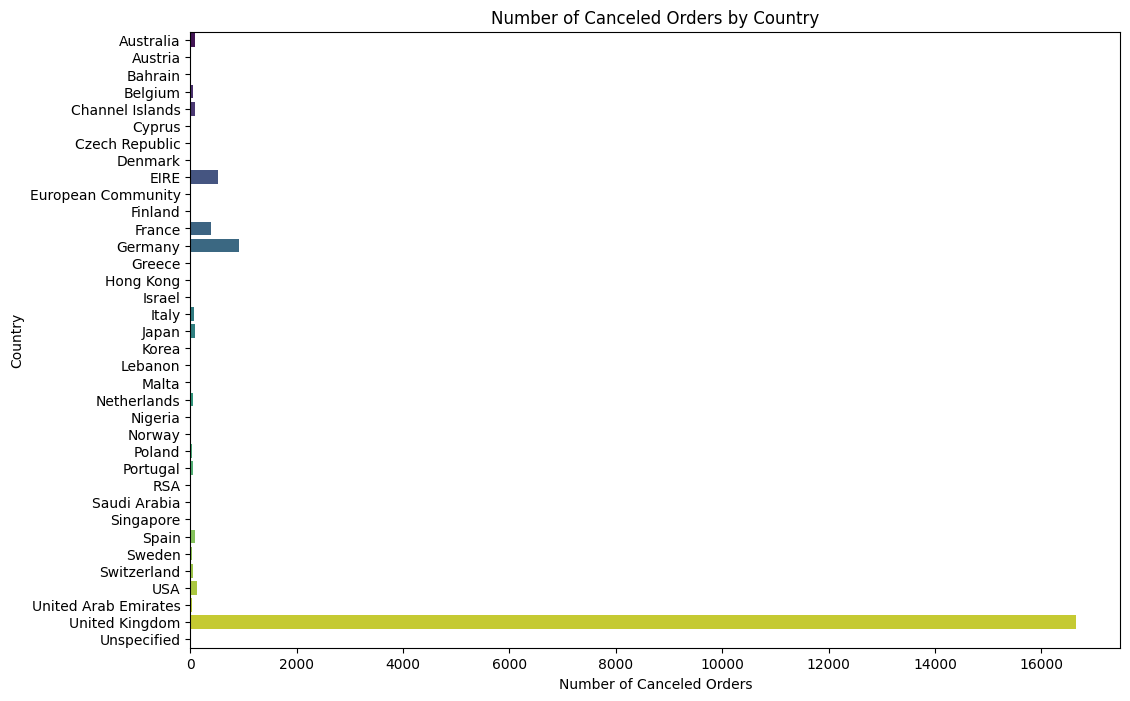

In [38]:
canceled_orders_by_country = df[df['Invoice'].str.contains('C', na=False)].groupby('Country')['Invoice'].count()

plt.figure(figsize=(12, 8))
sns.barplot(x=canceled_orders_by_country.values, y=canceled_orders_by_country.index, palette='viridis')
plt.xlabel('Number of Canceled Orders')
plt.ylabel('Country')
plt.title('Number of Canceled Orders by Country')
plt.show()

#### Pie Chart for Cancelled vs. Non-Cancelled Orders

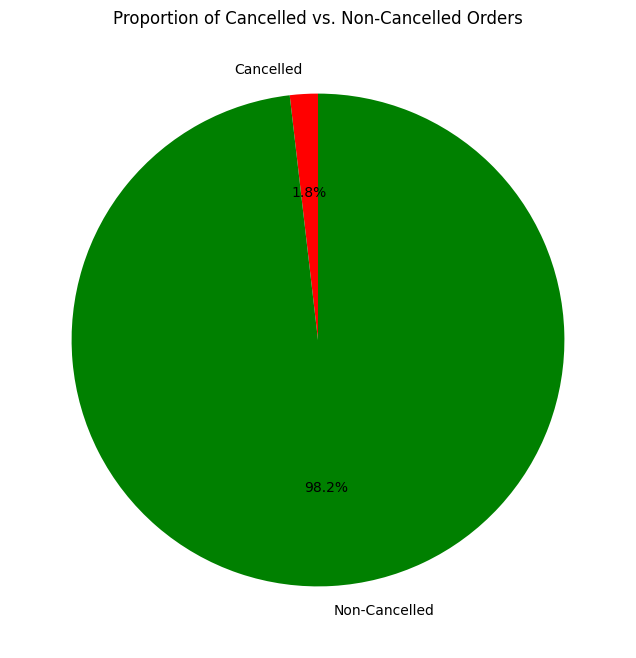

In [39]:
cancelled_count = df[df['Invoice'].str.contains('C', na=False)].shape[0]
non_cancelled_count = df.shape[0] - cancelled_count

plt.figure(figsize=(8, 8))
plt.pie([cancelled_count, non_cancelled_count], labels=['Cancelled', 'Non-Cancelled'], autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
plt.title('Proportion of Cancelled vs. Non-Cancelled Orders')
plt.show()


### Inference - 

1. In the case of cancelled transactions, denoted by 'C' at the start of the invoice, it is expected that the quantity and price would be 0 or negative. However, the quantity with values less than or equal to 0 exceeds the count of cancelled transactions.

2. This discrepancy indicates data irregularities in terms of quantity, suggesting the need to exclude such rows from the dataset.

3. Cancelling a transaction resulted in the system recording a negative amount. Therefore, excluding invoices containing "C" should resolve this issue.

4. The proportion of cancelled transactions is 1.8%. This could be attributed to various reasons such as product returns due to issues or customer dissatisfaction, last-minute changes in customer decisions, production line problems, or other business challenges.

5. Despite the presence of cancelled transactions, the majority of orders are non-cancelled, signaling a positive trend for the business. However, the 'cancelled' segment warrants further scrutiny to understand the underlying reasons for its occurrence.

In [40]:
print("Before dropping, number of records = {}".format(df.shape[0]))
df.drop(df[df['Invoice'].str.contains('C', na=False)].index, inplace=True)
print("After dropping, number of records = {}".format(df.shape[0]))

Before dropping, number of records = 1062989
After dropping, number of records = 1043495


In [41]:
print("Before dropping, number of records = {}".format(df.shape[0]))
df.drop(df[df['Price'] <= 0].index, inplace=True)
df.drop(df[df['Quantity'] <= 0].index, inplace=True)
print("After dropping, number of records = {}".format(df.shape[0]))

Before dropping, number of records = 1043495
After dropping, number of records = 1041670


In [42]:
price = df.loc[df['Price'] <= 0, 'Price'].count()
quantity = df.loc[df['Quantity'] <= 0, 'Quantity'].count()

print("Number of records with negative or zero - ")
print("Price = {} \nQuantity = {}".format(price, quantity))

contains_c = df.loc[df['Invoice'].str.contains('C'), ['Invoice']].count()
print("Number of records with Invoice containing 'C' = {}".format(contains_c[0]))

Number of records with negative or zero - 
Price = 0 
Quantity = 0


Number of records with Invoice containing 'C' = 0


### Handling Outliers

In [43]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [55]:
print('All columns of Data Frame = {}'.format(df.columns.tolist()))

numeric_columns = df.select_dtypes(include = ['number']).columns

print('\nNumeric Columns of the Data Frame = {}'.format(numeric_columns.tolist()))

All columns of Data Frame = ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

Numeric Columns of the Data Frame = ['Quantity', 'Price', 'Customer ID']


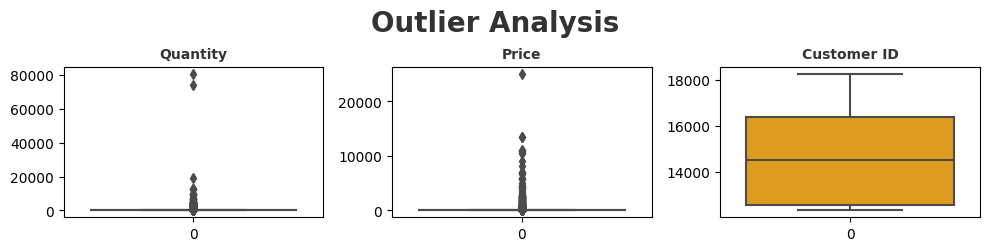

In [67]:
numeric_columns = df[numeric_columns]

plt.figure(figsize=(10, 10))
plt.suptitle('Outlier Analysis', fontsize=20, fontweight='bold', alpha=0.8)

for i, column in enumerate(numeric_columns.columns):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(numeric_columns[column], color='orange')
    plt.title(column, fontsize=10, fontweight='bold', alpha=0.8)
    plt.tight_layout()

plt.show()


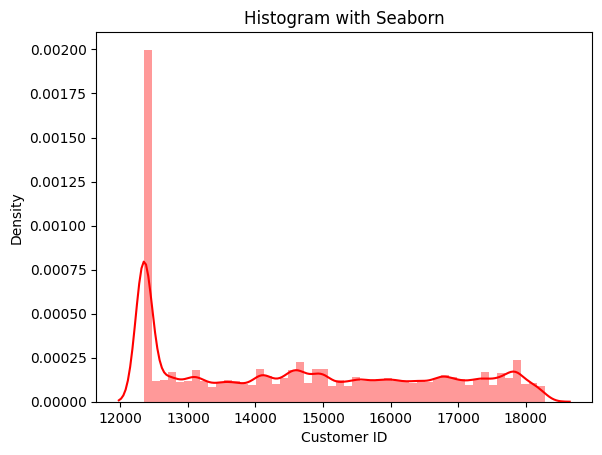

In [80]:
sns.distplot(numeric_columns['Customer ID'], kde=True, color='red')
plt.title('Histogram with Seaborn')
plt.show()

### Observations from the plot

1. Outliers are definitely present in quantity and price column.
2. IQR can be used but we need to be specific about the range we choose as 25-75 is the ideal range to capture the central tendency of the data but we are dealing with data which is sensitive to extreme values as they would decide the behaviour of the customer and segment accordingly.

In [ ]:
numeric_columns.describe()

,Quantity,Price,Customer ID
count,1.041670e+06,1.041670e+06,1.041670e+06
mean,1.096346e+01,4.076683e+00,1.465556e+04
std,1.265150e+02,5.144773e+01,1.946132e+03
min,1.000000e+00,1.000000e-03,1.234300e+04
25%,1.000000e+00,1.250000e+00,1.256200e+04
50%,3.000000e+00,2.100000e+00,1.452700e+04
75%,1.000000e+01,4.130000e+00,1.638700e+04
max,8.099500e+04,2.511109e+04,1.828700e+04


In [81]:
numeric_columns.describe([0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 
                          0.60, 0.70, 0.80, 0.90, 0.95, 0.98, 0.99, 1]).T

,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,98%,99%,100%,max
Quantity,1041670.0,10.963458,126.514990,1.000,1.00,1.00,1.00,1.00,2.00,2.00,3.0,6.00,8.00,12.00,24.00,30.00,72.00,100.0,80995.00,80995.00
Price,1041670.0,4.076683,51.447730,0.001,0.29,0.42,0.65,1.06,1.25,1.65,2.1,2.95,3.75,4.95,7.95,9.95,14.95,18.0,25111.09,25111.09
Customer ID,1041670.0,14655.561255,1946.132344,12343.000,12345.00,12345.00,12345.00,12345.00,12944.00,13767.00,14527.0,15122.00,15981.00,16778.00,17567.00,17841.00,18079.00,18172.0,18287.00,18287.00


### Inference from the describe - 

1. For customer ID we cannot do any outlier analysis as it is a unique column. 
2. Quantity has a consistent range throughout the scale but at 100% which is 80995.00 which means this is the outlier. 
3. Price has relatively small outlier at the beginning of the scale (1%) and very high at the end of the scale (100%).

### In terms of RFM analysis and Customer Segmentation - 

1. For RFM & customer segmentation, we generally want to identify and understand the distribution of RFM variables to create meaningful segments.
2. __*Recency*__ - 
    - recency represents the number of days since the last purchase, we may want to prioritize recent customers. In this case, we might consider using a smaller quartile range, such as 5% to 95%, to focus on the central portion of the distribution. Example: 5% to 95% or 10% to 90%.
3. __*Frequency*__ -
    - Frequency represents how often a customer makes a purchase. We may want to identify both frequent and infrequent customers. A wider quartile range like 1% to 99% can capture the extremes in frequency. Example: 1% to 99% or 5% to 95%.

4. __*Monetary*__ -
    - Monetary value represents the total spending of a customer. We might want to capture both high-spending and low-spending customers. A wider quartile range is suitable for capturing the full range of spending. Example: 1% to 99% or 5% to 95%.

5. To capture the full spectrum of customer behaviour, we have to satisfy all 3 aspects which leads to IQR range of 1-99.


In [104]:
to_remove_outlier = ['Quantity', 'Price']

print('1 percentile value of Quantity = {}'.format(numeric_columns['Quantity'].quantile(0.01)))
print('\n99 percentile value of Quantity = {}'.format(numeric_columns['Quantity'].quantile(0.99)))

print('\n\n1 percentile value of Price = {}'.format(numeric_columns['Price'].quantile(0.01)))
print('\n99 percentile value of Price = {}'.format(numeric_columns['Price'].quantile(0.99)))

1 percentile value of Quantity = 1.0

99 percentile value of Quantity = 100.0


1 percentile value of Price = 0.29

99 percentile value of Price = 18.0


In [106]:
def outlier(df, to_remove_outlier):
    for column in to_remove_outlier:
        q1 = df[column].quantile(0.01)  # 1%
        q3 = df[column].quantile(0.99)  # 99%

        iqr = q3 - q1

        lower_fence = q1 - 1.5 * iqr
        upper_fence = q3 + 1.5 * iqr

        df[column] = np.where(df[column] < lower_fence, lower_fence,
                              np.where(df[column] > upper_fence, upper_fence,
                                       df[column]))

    return df

df = outlier(df, to_remove_outlier)

In [108]:
print('Minimum and Maximum of Quantity = {}, {}'.format(df['Quantity'].min(), df['Quantity'].max()))
print('Minimum and Maximum of Price = {}, {}'.format(df['Price'].min(), df['Price'].max()))

Minimum and Maximum of Quantity = 1.0, 248.5
Minimum and Maximum of Price = 0.001, 44.565


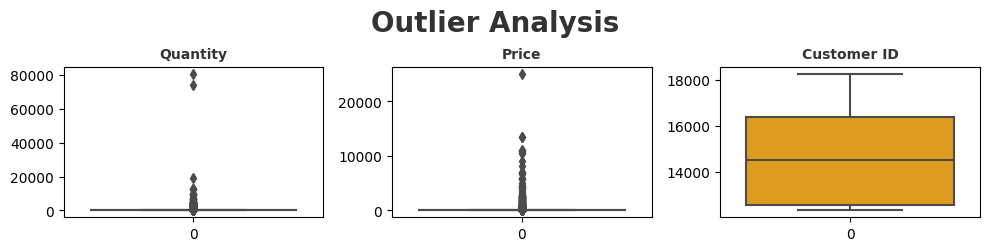

In [92]:
plt.figure(figsize=(10, 10))
plt.suptitle('Outlier Analysis', fontsize=20, fontweight='bold', alpha=0.8)

for i, column in enumerate(numeric_columns.columns):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(numeric_columns[column], color='orange')
    plt.title(column, fontsize=10, fontweight='bold', alpha=0.8)
    plt.tight_layout()

plt.show()

In [110]:
q1 = df['Quantity'].quantile(0.01)  # 1%
q3 = df['Quantity'].quantile(0.99)  # 99%

print('lower fence and upper fence of Quantity = {}, {}'.format(q1 - (q3-q1)*1.5, q3 + (q3-q1)*1.5))

lower fence and upper fence of Quantity = -147.5, 248.5


In [111]:
q1 = df['Price'].quantile(0.01)  # 1%
q3 = df['Price'].quantile(0.99)  # 99%

print('lower fence and upper fence of Price = {}, {}'.format(q1 - (q3-q1)*1.5, q3 + (q3-q1)*1.5))

lower fence and upper fence of Price = -26.275000000000002, 44.565


In [113]:
df.shape

(1041670, 8)

### Top 10 best selling product

In [121]:
product = df.groupby('Description')['Quantity'].count().nlargest(10)
product

Description
WHITE HANGING HEART T-LIGHT HOLDER    5778
REGENCY CAKESTAND 3 TIER              4061
JUMBO BAG RED RETROSPOT               3391
ASSORTED COLOUR BIRD ORNAMENT         2938
PARTY BUNTING                         2740
LUNCH BAG  BLACK SKULL.               2484
STRAWBERRY CERAMIC TRINKET BOX        2427
JUMBO STORAGE BAG SUKI                2398
HEART OF WICKER SMALL                 2293
JUMBO SHOPPER VINTAGE RED PAISLEY     2274
Name: Quantity, dtype: int64

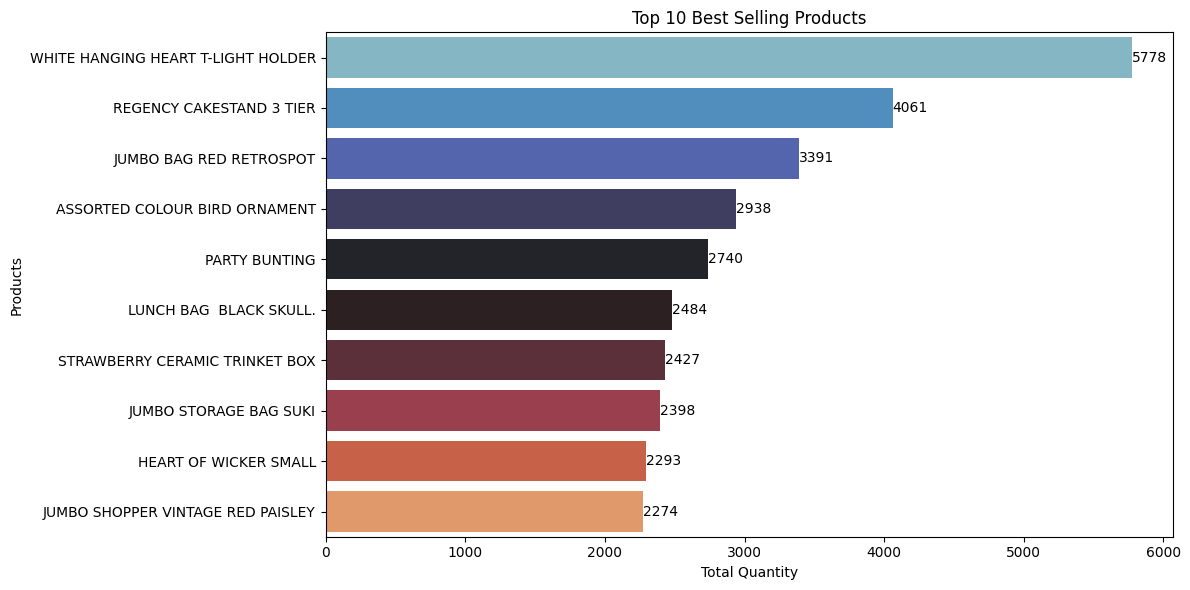

In [130]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=product.reset_index(), x="Quantity", y="Description", palette="icefire")

for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center')

ax.set_title("Top 10 Best Selling Products")
plt.xlabel("Total Quantity")
plt.ylabel("Products")
plt.tight_layout()
plt.show()

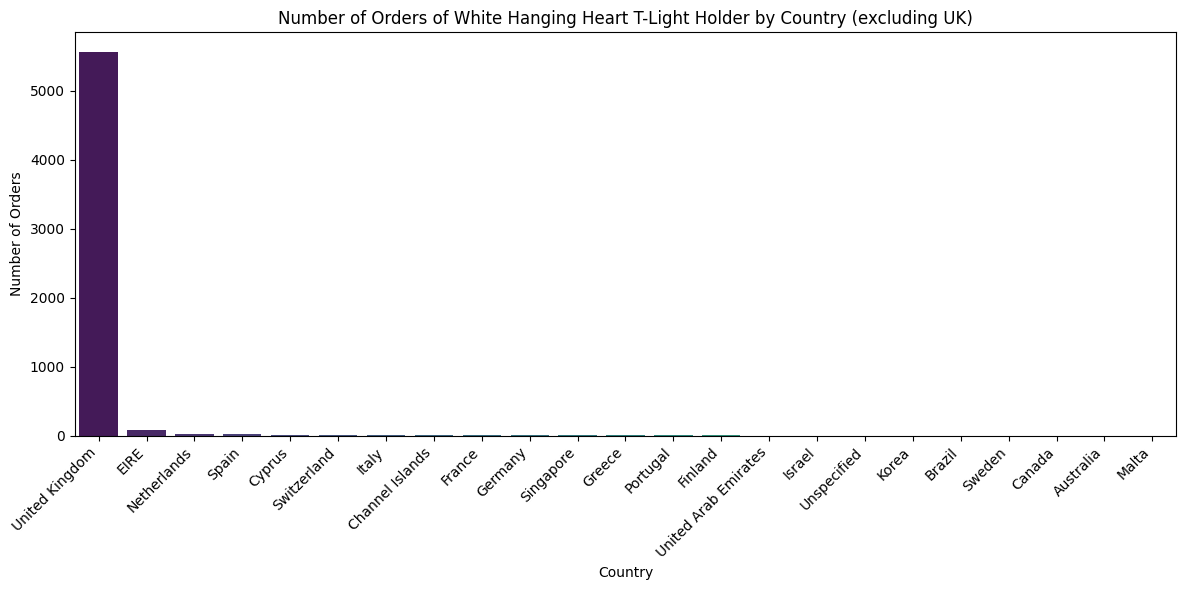

In [142]:
## Finding out which country, after UK, has the highest number of orders of "White Hanging Heart T-Light Holder"

white_heart = df.loc[df['Description'] == 'WHITE HANGING HEART T-LIGHT HOLDER', ['Country', 'Description']]

plt.figure(figsize=(12,6))
sns.countplot(x='Country', data=white_heart, order=white_heart['Country'].value_counts().index, palette='viridis')
plt.title('Number of Orders of White Hanging Heart T-Light Holder by Country (excluding UK)')
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [143]:
white_heart['Country'].value_counts().nlargest(10)

Country
United Kingdom     5569
EIRE                 87
Netherlands          28
Spain                20
Cyprus               14
Switzerland           9
Italy                 7
Channel Islands       7
France                7
Germany               6
Name: count, dtype: int64

### Graph Inference

1. The countries with the most substantial orders for the "White Hanging Heart T-Light Holder" are the United Kingdom, EIRE (Ireland), and the Netherlands.<br><br>
2. The heightened demand for this particular product in these nations suggests potential influences from shared cultural traits or common interests, possibly contributing to the increased order quantities. Conversely, lower popularity in other countries may be linked to cultural differences and distinct preferences.

### Finding out which gifts are bought the most in each continent.

In [ ]:
# ! Europe ! - United Kingdom, Germany, France, Spain, Belgium, Portugal, Netherlands, Switzerland, Sweden, Italy, 
# Finland, Channel Islands, Austria, Norway, Denmark, Cyprus, Poland, Greece, EIRE, Malta, Iceland, Czech Republic, 
# European Community, Lithuania

# ! Asia ! - Japan, Korea, Thailand, Singapore, Hong Kong

# ! North America ! - USA, Canada, West Indies, Bermuda

# ! Middle East ! - United Arab Emirates

# ! Africa ! - RSA, Nigeria

# ! South America ! - Brazil

# ! Unspecified ! - Unspecified

In [154]:
selected_continents = ['Asia', 'North America', 'Middle East', 'Africa', 'South America', 'Unspecified']
df['Continent'] = df['Country'].map(country_to_continent_mapping)

filtered_df = df[df['Continent'].isin(selected_continents)]

gift_quantities = filtered_df.groupby(['Continent', 'Description'])['Quantity'].sum().reset_index()

most_bought_gifts = gift_quantities.loc[gift_quantities.groupby('Continent')['Quantity'].idxmax()]

most_bought_gifts[['Continent', 'Description', 'Quantity']]

,Continent,Description,Quantity
92,Africa,PINK POLKADOT PLATE,104.0
582,Asia,PACK OF 12 TRADITIONAL CRAYONS,938.5
1051,Middle East,BOYS ALPHABET IRON ON PATCHES,248.5
2215,North America,TOAST ITS - I LOVE YOU,368.5
2283,South America,DOLLY GIRL LUNCH BOX,25.0
2389,Unspecified,60 TEATIME FAIRY CAKE CASES,146.0


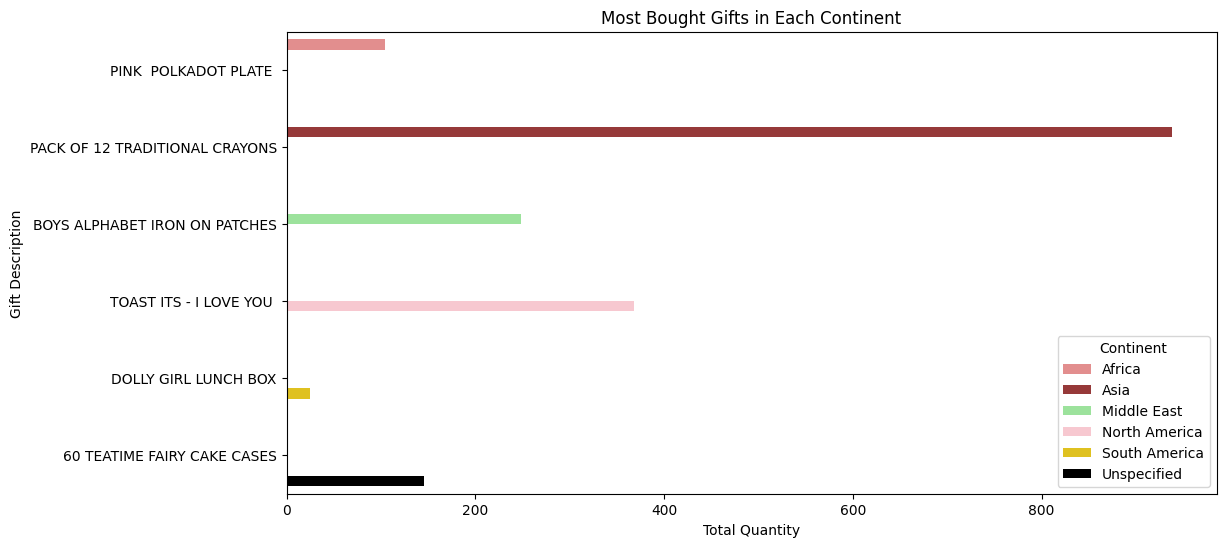

In [159]:
colors = {'Asia': 'brown', 'North America': 'pink', 'Middle East': 'lightgreen',
          'Africa': 'lightcoral', 'South America': 'gold', 'Unspecified': 'black'}

plt.figure(figsize=(12, 6))
sns.barplot(x='Quantity', y='Description', hue='Continent', data=most_bought_gifts, palette=colors)
plt.title('Most Bought Gifts in Each Continent')
plt.xlabel('Total Quantity')
plt.ylabel('Gift Description')
plt.show()

### Inference - 

1. Every continent has different gifts as their leading 'buy'. 
2. Asia has "Pack of 12 TRADITIONAL CRAYONS" which is very famous amongst young ones.

## RFM Analysis/Modelling

__*RFM Modeling Explained*__:

RFM (Recency, Frequency, Monetary) modeling is a powerful technique in data analysis used for customer segmentation based on their transaction behavior. RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.


Here's a breakdown of its components:

1. <u>Recency (R)</u>:

- Focuses on how recently a customer made a purchase.
- Recent customers might be more engaged and responsive.
<br>

2. <u>Frequency (F)</u>:

- Examines how often a customer makes a purchase.
- High-frequency customers are likely to be loyal.
<br>

3. <u>Monetary Value (M)</u>:

- Analyzes the total monetary value of a customer's purchases.
- High monetary value indicates valuable customers.

In [196]:
print('First Date in the column = {}\nLast Date in the column = {}'.format(df['InvoiceDate'].min(), df['InvoiceDate'].max()))

First Date in the column = 2009-12-01 07:45:00
Last Date in the column = 2011-12-09 12:50:00


In [204]:
#We will assign the next day after the last date recorded in the dataset as 'today_date'
today_date = dt.datetime(2011, 12, 10)
today_date

datetime.datetime(2011, 12, 10, 0, 0)

In [202]:
## Changing the date to datetime format
df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64[ns]')
print('After changing, the format = {}'.format(df['InvoiceDate'].dtype))

After changing, the format = datetime64[ns]


In [203]:
df['InvoiceDate']

0         2009-12-01 07:45:00
1         2009-12-01 07:45:00
2         2009-12-01 07:45:00
3         2009-12-01 07:45:00
4         2009-12-01 07:45:00
                  ...        
1067366   2011-12-09 12:50:00
1067367   2011-12-09 12:50:00
1067368   2011-12-09 12:50:00
1067369   2011-12-09 12:50:00
1067370   2011-12-09 12:50:00
Name: InvoiceDate, Length: 1041670, dtype: datetime64[ns]

- Recency is calculated by subtracting today_date - the last day the customer made a purchase
<br>

- Frequency is calculated by getting the unique count of Invoices
<br>

- Monetary value is calculated by getting the sum of totalprice

In [205]:
df['TotalPrice'] = df['Quantity'] * df['Price']
df.groupby("Customer ID")["TotalPrice"].sum()

Customer ID
12343.0        873.670
12344.0      14157.640
12345.0    2632145.660
12346.0        631.300
12347.0       5633.320
              ...     
18283.0       2736.650
18284.0        456.245
18285.0        421.565
18286.0       1290.995
18287.0       4177.555
Name: TotalPrice, Length: 5881, dtype: float64

In [321]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [322]:
rfm = rfm.reset_index()
rfm

,Customer ID,InvoiceDate,Invoice,TotalPrice
0,12343.0,631,1,873.670
1,12344.0,25,15,14157.640
2,12345.0,0,2994,2632145.660
3,12346.0,325,12,631.300
4,12347.0,2,8,5633.320
...,...,...,...,...
5876,18283.0,3,22,2736.650
5877,18284.0,431,1,456.245
5878,18285.0,660,1,421.565
5879,18286.0,476,2,1290.995


In [323]:
rfm.columns = ['CustomerID','Recency', 'Frequency', 'Monetary']
rfm

,CustomerID,Recency,Frequency,Monetary
0,12343.0,631,1,873.670
1,12344.0,25,15,14157.640
2,12345.0,0,2994,2632145.660
3,12346.0,325,12,631.300
4,12347.0,2,8,5633.320
...,...,...,...,...
5876,18283.0,3,22,2736.650
5877,18284.0,431,1,456.245
5878,18285.0,660,1,421.565
5879,18286.0,476,2,1290.995


In [324]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,5881.000000,5881.000000,5881.000000,5.881000e+03
mean,15313.797823,200.724537,6.814657,3.251063e+03
std,1716.446937,209.419121,41.081667,3.660774e+04
min,12343.000000,0.000000,1.000000,2.950000e+00
25%,13831.000000,25.000000,1.000000,3.424500e+02
50%,15313.000000,95.000000,3.000000,8.800400e+02
75%,16797.000000,379.000000,7.000000,2.252440e+03
max,18287.000000,738.000000,2994.000000,2.632146e+06


In [325]:
print(rfm.dtypes)


CustomerID    float64
Recency         int64
Frequency       int64
Monetary      float64
dtype: object


In [326]:
rfm

,CustomerID,Recency,Frequency,Monetary
0,12343.0,631,1,873.670
1,12344.0,25,15,14157.640
2,12345.0,0,2994,2632145.660
3,12346.0,325,12,631.300
4,12347.0,2,8,5633.320
...,...,...,...,...
5876,18283.0,3,22,2736.650
5877,18284.0,431,1,456.245
5878,18285.0,660,1,421.565
5879,18286.0,476,2,1290.995


In [327]:
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()
quantiles

{'CustomerID': {0.25: 13831.0, 0.5: 15313.0, 0.75: 16797.0},
 'Recency': {0.25: 25.0, 0.5: 95.0, 0.75: 379.0},
 'Frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 7.0},
 'Monetary': {0.25: 342.45000000000005, 0.5: 880.04, 0.75: 2252.44}}

In [328]:
def r_scoring(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

def f_and_m_scoring(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Recency score - The lower the recency, the better the score.
# Frequency and Monetary score - The higher the frequency and monetary, the better the score.

In [329]:
rfm['R'] = rfm['Recency'].apply(r_scoring, args=('Recency',quantiles,))
rfm['F'] = rfm['Frequency'].apply(f_and_m_scoring, args=('Frequency',quantiles,))
rfm['M'] = rfm['Monetary'].apply(f_and_m_scoring, args=('Monetary',quantiles,))
rfm

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12343.0,631,1,873.670,1,1,2
1,12344.0,25,15,14157.640,4,4,4
2,12345.0,0,2994,2632145.660,4,4,4
3,12346.0,325,12,631.300,2,4,2
4,12347.0,2,8,5633.320,4,4,4
...,...,...,...,...,...,...,...
5876,18283.0,3,22,2736.650,4,4,4
5877,18284.0,431,1,456.245,1,1,2
5878,18285.0,660,1,421.565,1,1,2
5879,18286.0,476,2,1290.995,1,2,3


In [330]:
# Calculate RFMGroup value by concatenating R, F, M values
rfm['RFMGroup'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)

# Calculate RFMScore value by adding R, F, M (or RFMGroup) values
rfm['RFMScore'] = rfm[['R', 'F', 'M']].sum(axis = 1)

rfm

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
0,12343.0,631,1,873.670,1,1,2,112,4
1,12344.0,25,15,14157.640,4,4,4,444,12
2,12345.0,0,2994,2632145.660,4,4,4,444,12
3,12346.0,325,12,631.300,2,4,2,242,8
4,12347.0,2,8,5633.320,4,4,4,444,12
...,...,...,...,...,...,...,...,...,...
5876,18283.0,3,22,2736.650,4,4,4,444,12
5877,18284.0,431,1,456.245,1,1,2,112,4
5878,18285.0,660,1,421.565,1,1,2,112,4
5879,18286.0,476,2,1290.995,1,2,3,123,6


In [331]:
# Labelling customers according to their RFM score with Loyalty Level
Loyalty_Level = ['Bronze', 'Silver', 'Gold', 'Platinum']
Score_cuts = pd.qcut(rfm.RFMScore, q = 4, labels = Loyalty_Level)
rfm['RFM_Loyalty_Level'] = Score_cuts.values

In [332]:
rfm

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12343.0,631,1,873.670,1,1,2,112,4,Bronze
1,12344.0,25,15,14157.640,4,4,4,444,12,Platinum
2,12345.0,0,2994,2632145.660,4,4,4,444,12,Platinum
3,12346.0,325,12,631.300,2,4,2,242,8,Gold
4,12347.0,2,8,5633.320,4,4,4,444,12,Platinum
...,...,...,...,...,...,...,...,...,...,...
5876,18283.0,3,22,2736.650,4,4,4,444,12,Platinum
5877,18284.0,431,1,456.245,1,1,2,112,4,Bronze
5878,18285.0,660,1,421.565,1,1,2,112,4,Bronze
5879,18286.0,476,2,1290.995,1,2,3,123,6,Silver


In [333]:
rfm['RFMGroup']

0       112
1       444
2       444
3       242
4       444
       ... 
5876    444
5877    112
5878    112
5879    123
5880    334
Name: RFMGroup, Length: 5881, dtype: object

In [334]:
rfm['RFM_Loyalty_Level'].value_counts()


RFM_Loyalty_Level
Bronze      1800
Gold        1694
Silver      1254
Platinum    1133
Name: count, dtype: int64

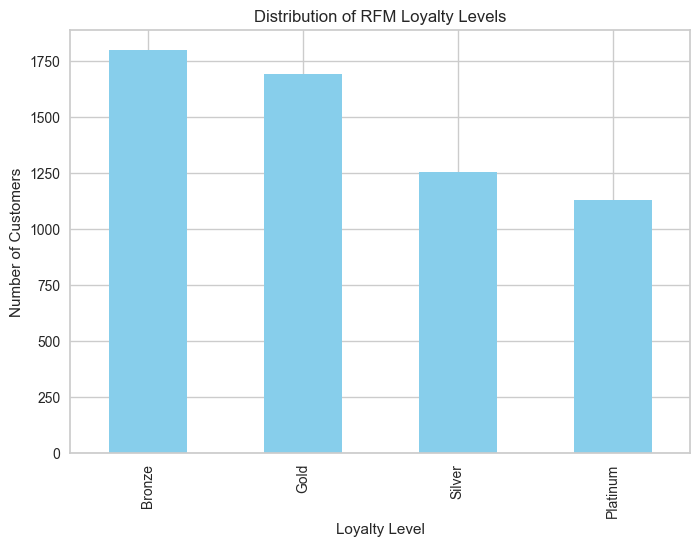

In [335]:
loyalty_level_counts = rfm['RFM_Loyalty_Level'].value_counts()

loyalty_level_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of RFM Loyalty Levels')
plt.xlabel('Loyalty Level')
plt.ylabel('Number of Customers')
plt.show()

## Inference

1. The presence of Platinum-level customers is minimal in the graph.
2. The graph indicates a higher concentration of Bronze-level customers, especially in segments with relatively lower scores.

## Possible Explanations for Loyalty Level Proportions

1. The prevalence of Bronze-level customers could signify a significant portion of newer or entry-level customers who are in the initial stages of establishing a relationship with the business. These customers may be exploring products/services or engaging in occasional purchases.

2. Depending on the specific industry or market dynamics, there may be a substantial number of price-sensitive customers or those who prioritize sporadic purchases over consistent engagement. These factors could contribute to the larger representation of the Bronze segment.

In [336]:
rfm

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12343.0,631,1,873.670,1,1,2,112,4,Bronze
1,12344.0,25,15,14157.640,4,4,4,444,12,Platinum
2,12345.0,0,2994,2632145.660,4,4,4,444,12,Platinum
3,12346.0,325,12,631.300,2,4,2,242,8,Gold
4,12347.0,2,8,5633.320,4,4,4,444,12,Platinum
...,...,...,...,...,...,...,...,...,...,...
5876,18283.0,3,22,2736.650,4,4,4,444,12,Platinum
5877,18284.0,431,1,456.245,1,1,2,112,4,Bronze
5878,18285.0,660,1,421.565,1,1,2,112,4,Bronze
5879,18286.0,476,2,1290.995,1,2,3,123,6,Silver


In [337]:
df['Customer ID'].nunique()

5881

## Feature Transformation

In [338]:
rfm

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12343.0,631,1,873.670,1,1,2,112,4,Bronze
1,12344.0,25,15,14157.640,4,4,4,444,12,Platinum
2,12345.0,0,2994,2632145.660,4,4,4,444,12,Platinum
3,12346.0,325,12,631.300,2,4,2,242,8,Gold
4,12347.0,2,8,5633.320,4,4,4,444,12,Platinum
...,...,...,...,...,...,...,...,...,...,...
5876,18283.0,3,22,2736.650,4,4,4,444,12,Platinum
5877,18284.0,431,1,456.245,1,1,2,112,4,Bronze
5878,18285.0,660,1,421.565,1,1,2,112,4,Bronze
5879,18286.0,476,2,1290.995,1,2,3,123,6,Silver


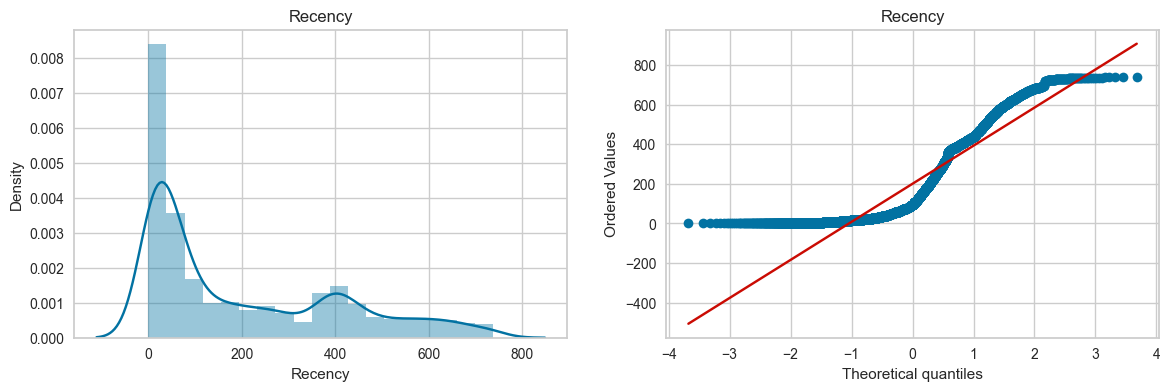

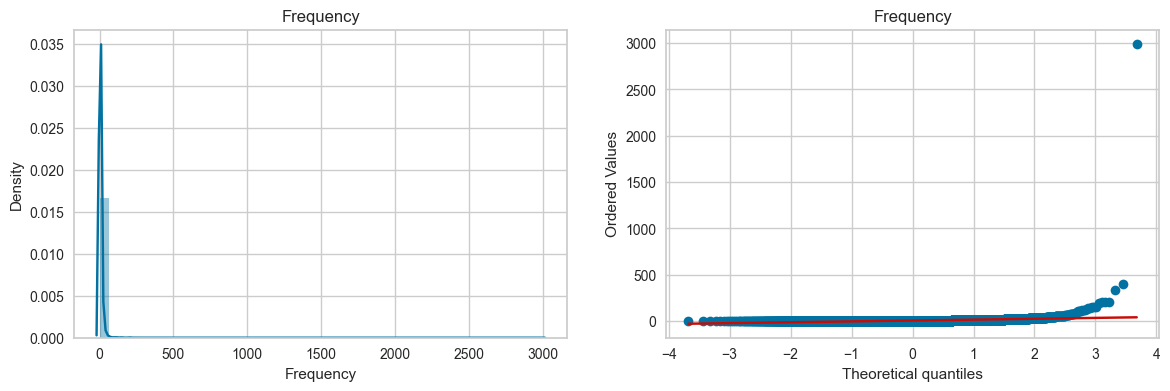

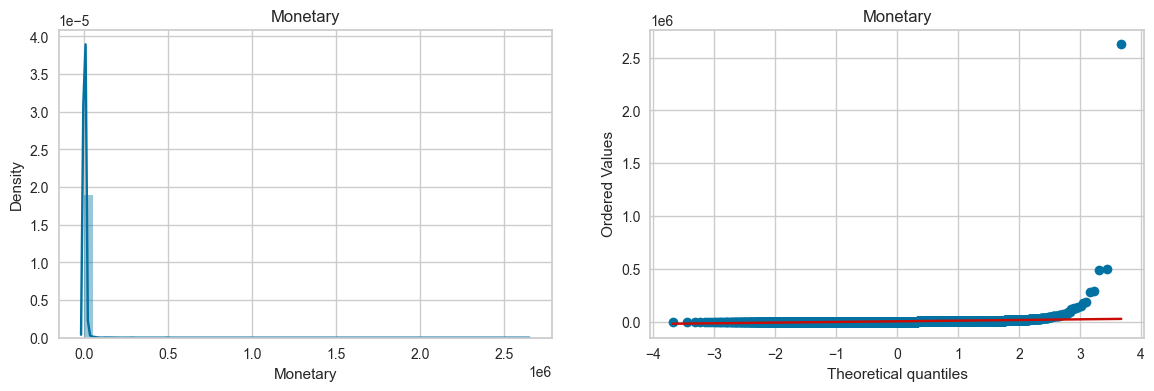

In [339]:
to_be_scaled = rfm[['Recency', 'Frequency', 'Monetary']]

for col in to_be_scaled.columns:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    sns.distplot(to_be_scaled[col])
    plt.title(col)

    plt.subplot(122)
    stats.probplot(to_be_scaled[col], dist="norm", plot=plt)
    plt.title(col)

    plt.show()

## Inference - 

1. Frequency and Monetary are almost normally distributed. 
2. Recency is off-grid and is right-skewed. 

In [341]:
scaler = StandardScaler()

print('Before scaling, the mean of the data = \n{}'.format(to_be_scaled.mean()))
scaled_rfm = scaler.fit_transform(to_be_scaled)
print('After scaling, the mean of the data = {}'.format(scaled_rfm.mean())) 

Before scaling, the mean of the data = 
Recency       200.724537
Frequency       6.814657
Monetary     3251.063328
dtype: float64
After scaling, the mean of the data = -8.860137270714847e-18


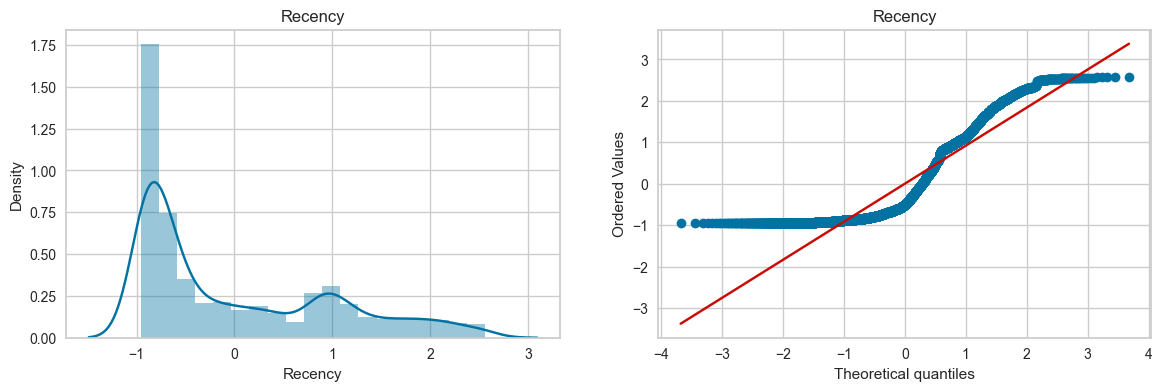

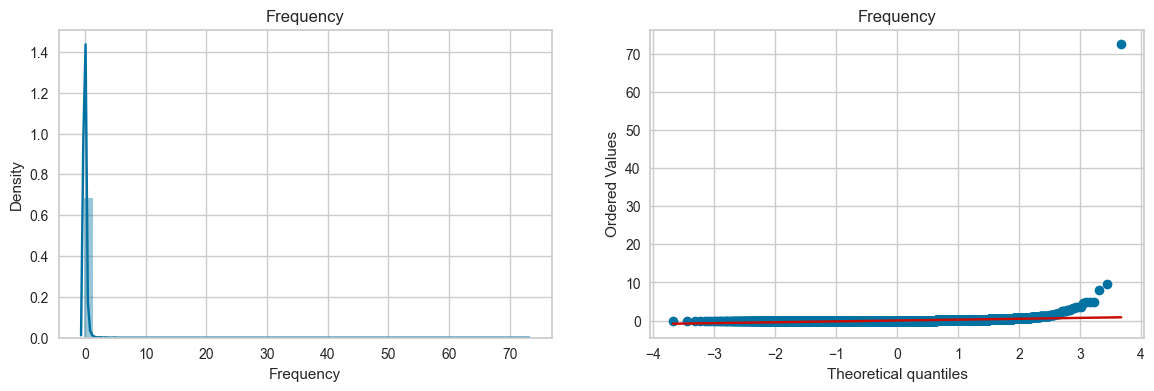

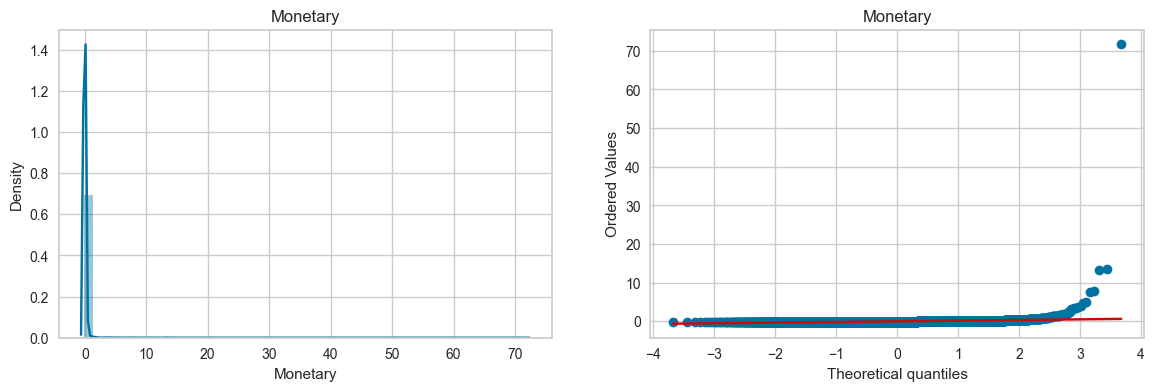

In [343]:
to_be_scaled = rfm[['Recency', 'Frequency', 'Monetary']]

scaled_rfm = pd.DataFrame(scaled_rfm, columns=to_be_scaled.columns)

for col in scaled_rfm.columns:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    sns.distplot(scaled_rfm[col])
    plt.title(col)

    plt.subplot(122)
    stats.probplot(scaled_rfm[col], dist="norm", plot=plt)
    plt.title(col)

    plt.show()

In [345]:
scaled_rfm

,Recency,Frequency,Monetary
0,2.054789,-0.141551,-0.064948
1,-0.839176,0.199263,0.297956
2,-0.958564,72.719525,71.818641
3,0.593480,0.126231,-0.071569
4,-0.949013,0.028856,0.065081
...,...,...,...
5876,-0.944237,0.369669,-0.014053
5877,1.099685,-0.141551,-0.076352
5878,2.193279,-0.141551,-0.077299
5879,1.314583,-0.117207,-0.053547


In [347]:
transformer = PowerTransformer(method='yeo-johnson', standardize=True)
rfm_scaled_recency = transformer.fit_transform(scaled_rfm['Recency'].values.reshape(-1, 1))

In [348]:
rfm_scaled_recency

array([[ 1.60357429],
       [-0.96150602],
       [-1.22051175],
       ...,
       [ 1.65087825],
       [ 1.30569148],
       [-0.79503206]])

In [351]:
scaled_rfm['Recency'] = rfm_scaled_recency
scaled_rfm

,Recency,Frequency,Monetary
0,1.603574,-0.141551,-0.064948
1,-0.961506,0.199263,0.297956
2,-1.220512,72.719525,71.818641
3,0.899887,0.126231,-0.071569
4,-1.199169,0.028856,0.065081
...,...,...,...
5876,-1.188538,0.369669,-0.014053
5877,1.200328,-0.141551,-0.076352
5878,1.650878,-0.141551,-0.077299
5879,1.305691,-0.117207,-0.053547


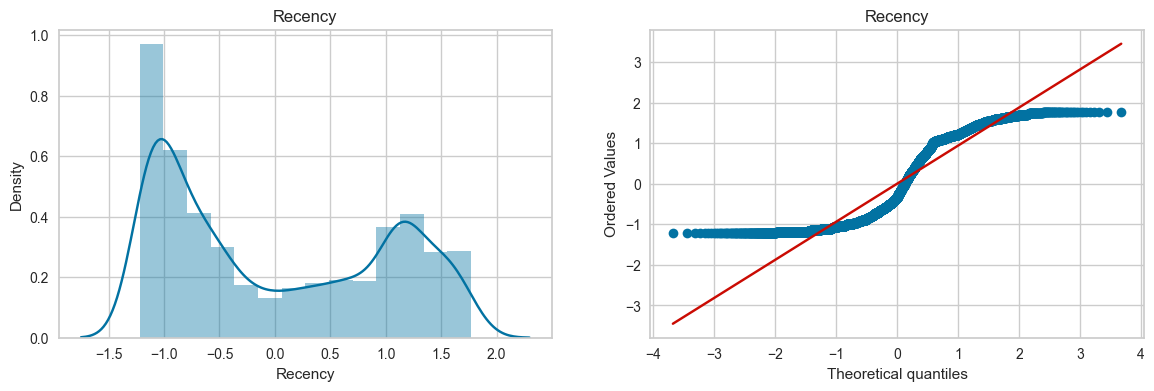

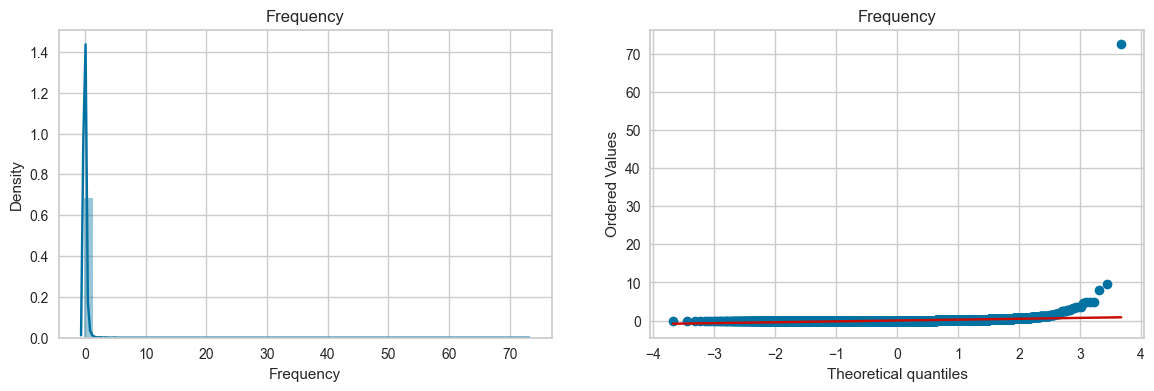

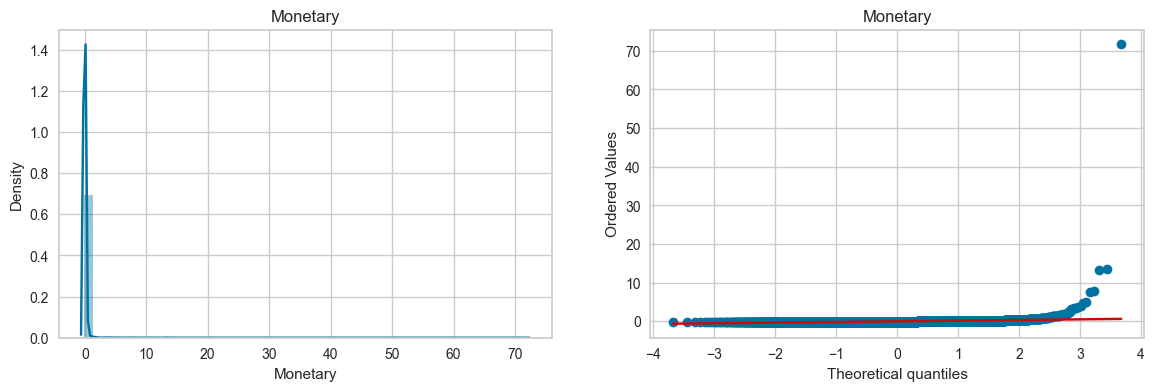

In [352]:
#to_be_scaled = rfm[['Recency', 'Frequency', 'Monetary']]

for col in scaled_rfm.columns:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    sns.distplot(scaled_rfm[col])
    plt.title(col)

    plt.subplot(122)
    stats.probplot(scaled_rfm[col], dist="norm", plot=plt)
    plt.title(col)

    plt.show()

# Transformation Steps

In the process of preparing the data for analysis, the following key steps were undertaken:

1. **Standard Scaling:**
   - Applied standard scaling to normalize all numerical values in the dataset.

2. **Transformation using Yeo-Johnson:**
   - Utilized the Yeo-Johnson transformation specifically on the 'Recency' column to achieve a more normal distribution.

## Transformation Results

The transformation yielded the following outcomes:

- **Bi-Modal Graph:**
  - The transformation resulted in a bi-modal graph, representing a distribution with two peaks, which is an improvement compared to the pre-transformed version. This transformation enhances the data distribution for more effective analysis.

## K-means clustering for segmenting the customers/wholesalers

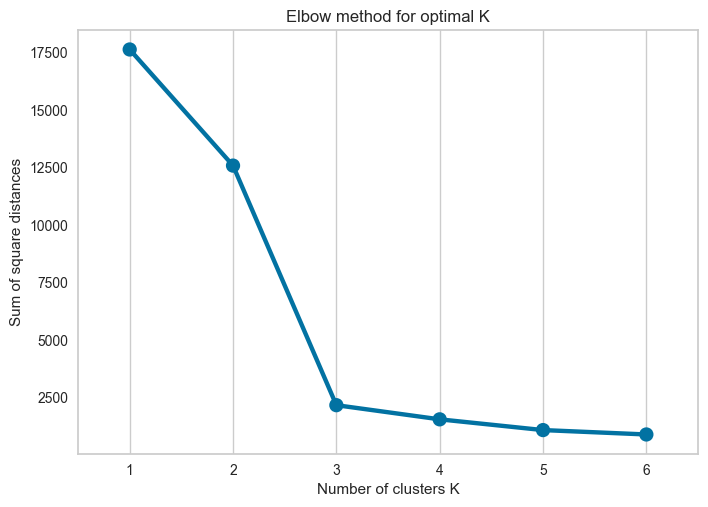

In [353]:
## to determine the value of k

wcss={}

for k in range(1,7):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000 , random_state=20)
    km = km.fit(scaled_rfm)
    wcss[k] = km.inertia_
    
#Plot graph for the wcss values and the number of clusters
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.xlabel('Number of clusters K')
plt.ylabel('Sum of square distances')
plt.title('Elbow method for optimal K')
plt.grid()
plt.show()

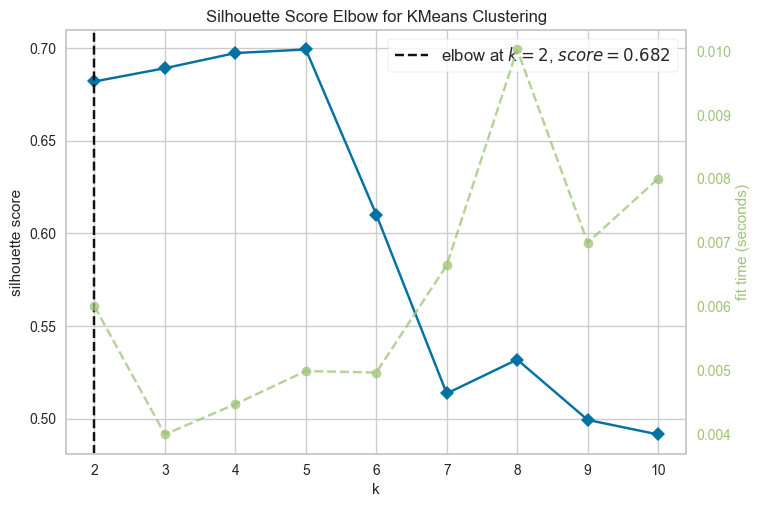

In [354]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,11), metric='silhouette')

visualizer.fit(scaled_rfm)
visualizer.show()
plt.show()

In [355]:
for i in range(2,11):
    clust = KMeans(n_clusters=i, random_state=23)
    clusters = clust.fit_predict(scaled_rfm)
    print("For ", i, " clusters, score is = ", silhouette_score(scaled_rfm, clusters))

For  2  clusters, score is =  0.6820349766255168
For  3  clusters, score is =  0.6891953220339186
For  4  clusters, score is =  0.5855572154170473
For  5  clusters, score is =  0.4810531813273886
For  6  clusters, score is =  0.4931139226052048
For  7  clusters, score is =  0.5152766487963221
For  8  clusters, score is =  0.5271653763292555
For  9  clusters, score is =  0.4904073829746153
For  10  clusters, score is =  0.49787474390018505


## Observation - 

1. Elbow Method - No. of optimal clusters = 3
<br>

2. KElbowVizualizer - No. of optimal clusters = 2 (0.682 silhouette score)
<br>

3. Manual Comparison of K vs Silhouette Score - No. of optimal clusters = 3 (0.689 silhouette score)

### Therefore, Number of clusters = 3

### Silhouette Score Analysis

For n_clusters = 2 The average silhouette_score is : 0.6820405175605218
For n_clusters = 3 The average silhouette_score is : 0.6891931520617542
For n_clusters = 4 The average silhouette_score is : 0.5893873775206452
For n_clusters = 5 The average silhouette_score is : 0.596987371540069
For n_clusters = 6 The average silhouette_score is : 0.6111927922778296
For n_clusters = 7 The average silhouette_score is : 0.5364408926887263


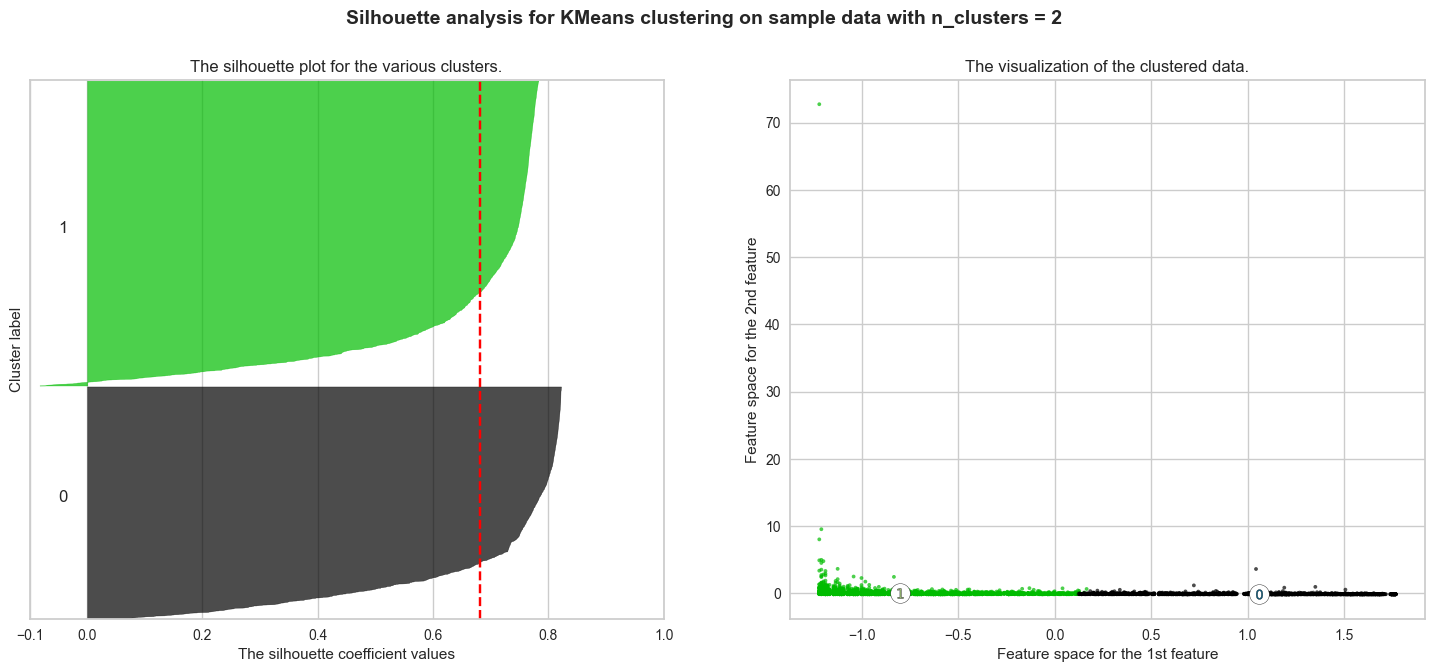

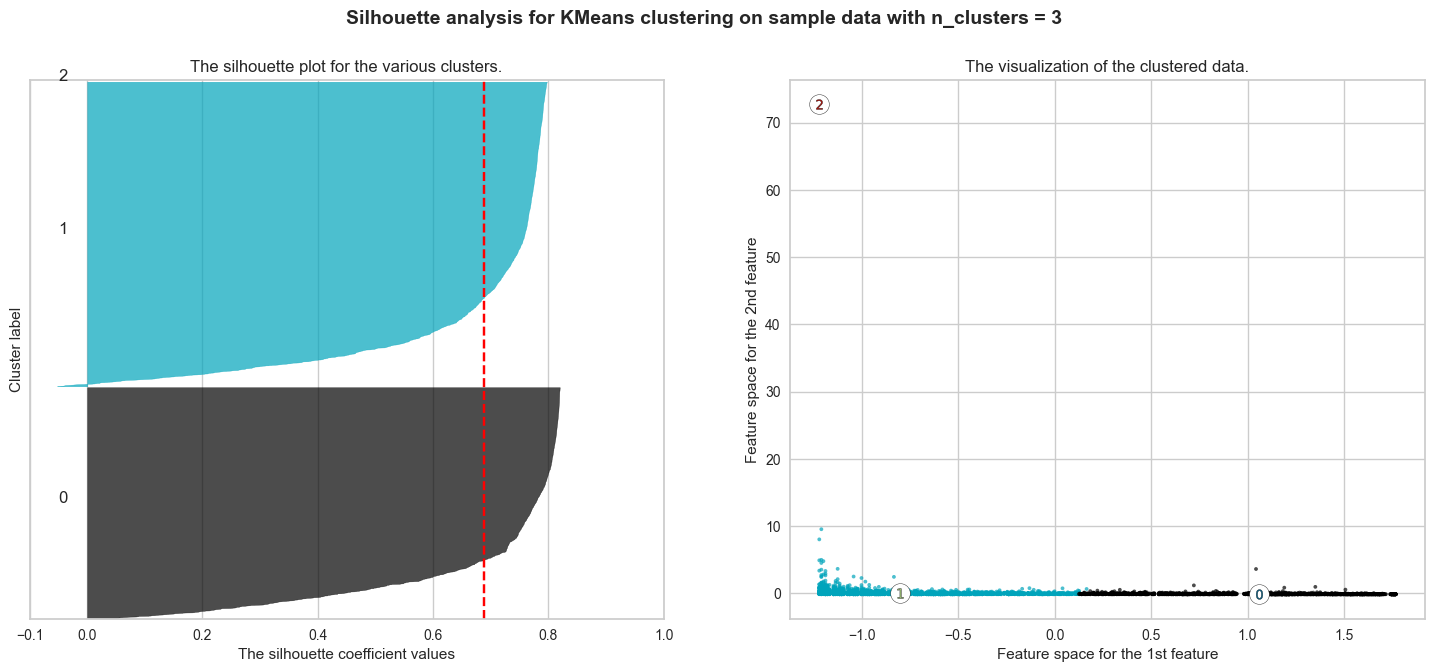

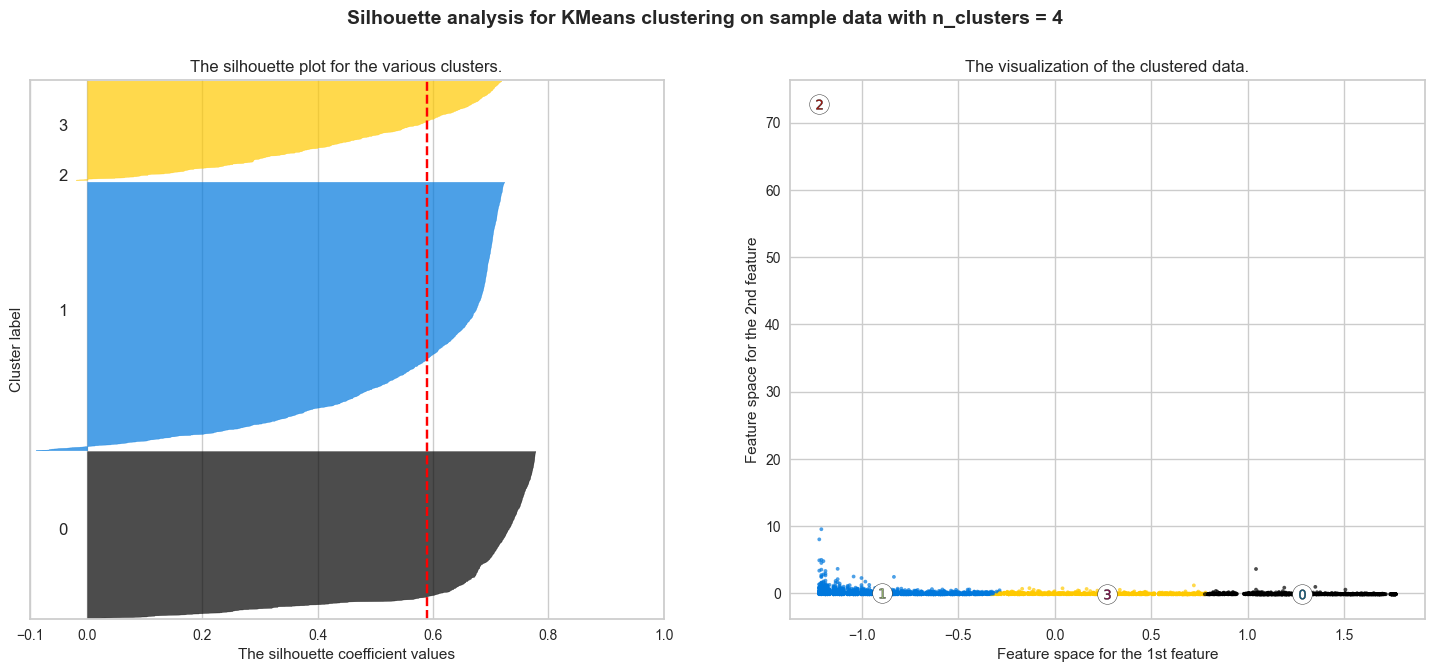

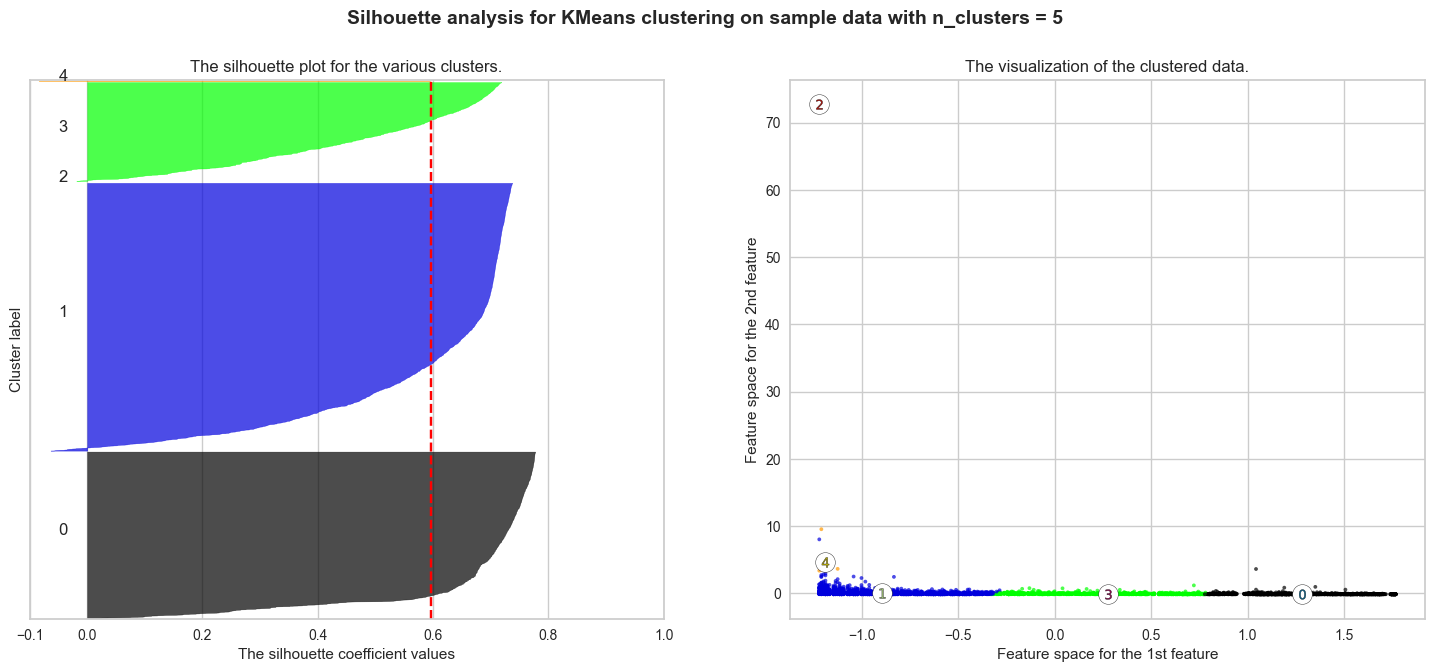

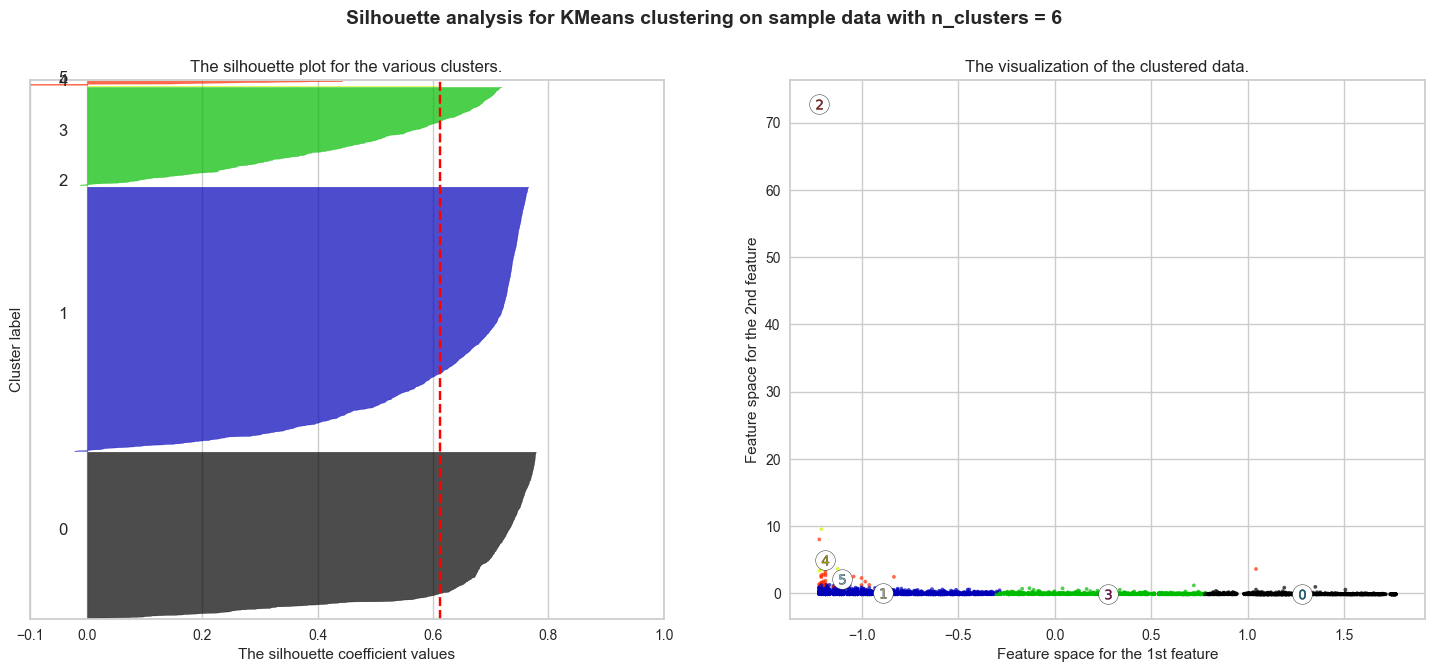

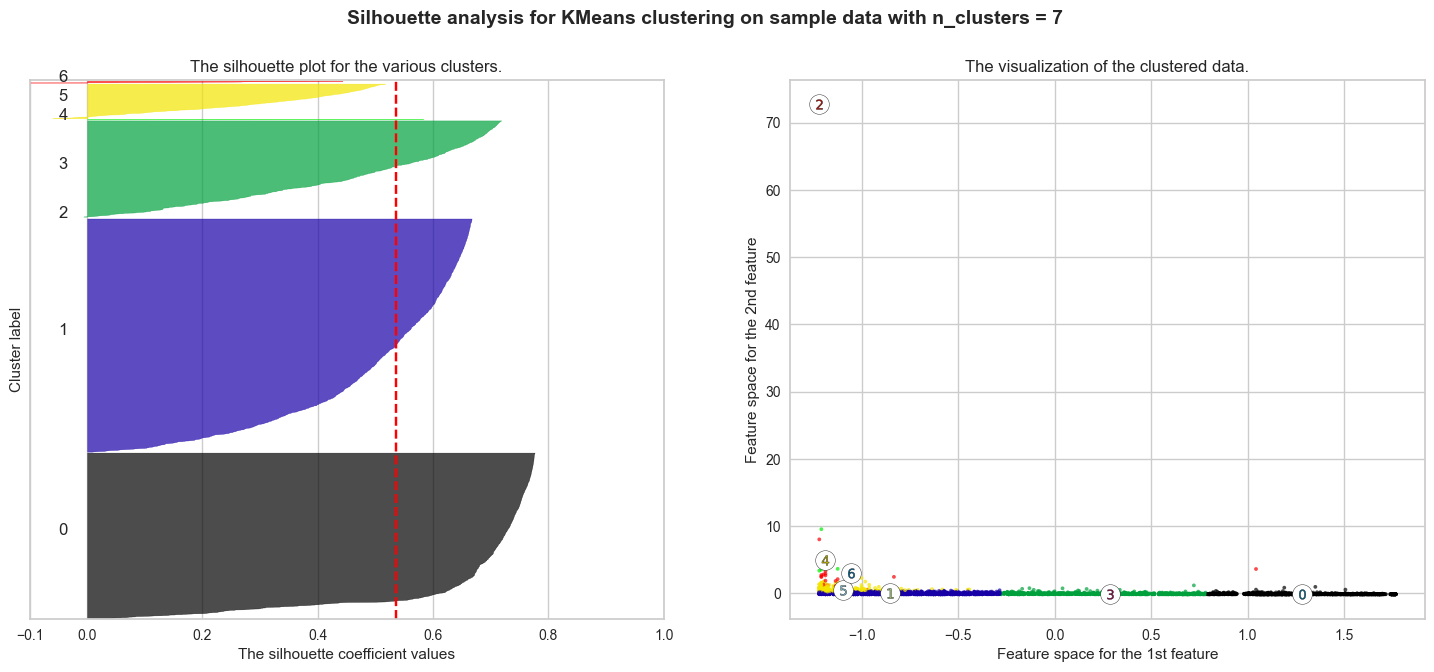

In [360]:
X = scaled_rfm.values
range_n_clusters = range(2,8)

range_n_clusters = range(2,8)

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [378]:
model = KMeans(n_clusters=3, init='k-means++', max_iter=1000, random_state=20)
model.fit(scaled_rfm)

rfm['Cluster'] = model.labels_ + 1 # Instead of starting from 0, we will start from 1

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
0,12343.0,631,1,873.67,1,1,2,112,4,Bronze,2,blue
1,12344.0,25,15,14157.64,4,4,4,444,12,Platinum,1,green
2,12345.0,0,2994,2632145.66,4,4,4,444,12,Platinum,3,green
3,12346.0,325,12,631.30,2,4,2,242,8,Gold,2,blue
4,12347.0,2,8,5633.32,4,4,4,444,12,Platinum,1,green


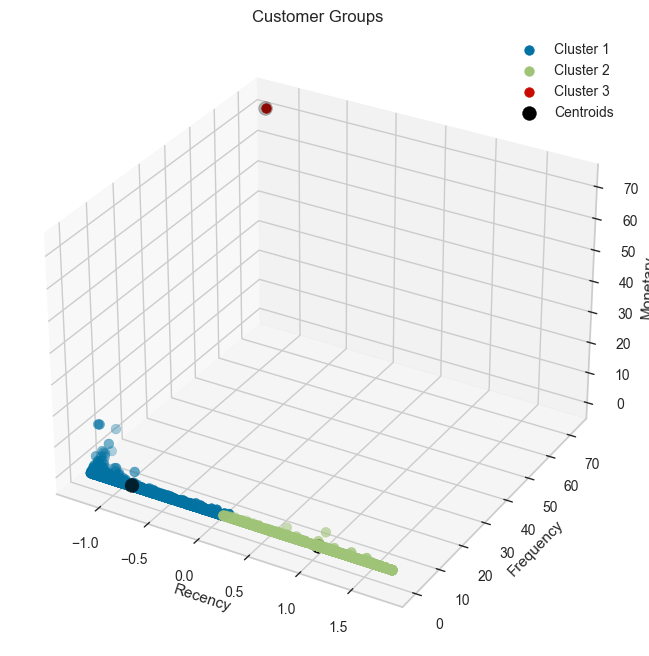

In [380]:
X = scaled_rfm.values
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster_num in range(3):
    ax.scatter(X[rfm['Cluster'] == cluster_num + 1, 0], 
               X[rfm['Cluster'] == cluster_num + 1, 1], 
               X[rfm['Cluster'] == cluster_num + 1, 2],
               s=50, label=f'Cluster {cluster_num + 1}')

# centroids
ax.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], model.cluster_centers_[:, 2],
           s=100, c='black', label='Centroids')

ax.set_title('Customer Groups')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.legend()
plt.show()